# SAFECOM Trend Analysis

This notebook provides an example of the trend analysis portion of the Hazard Extraction and Analysis of Trends framework. Trend analysis is applied the the SAFECOM dataset of wildfire aviation mishaps, available here: https://www.safecom.gov/ 

This example uses the trend analysis module from MIKA's knowledge discovery toolkit, as well as the Data utility and SAFECOM utilities. 

Prior to this analysis, hazard extraction is performed using the topic model plus module.

# Imports

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import textwrap
import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math
from sklearn.metrics import cohen_kappa_score
import pingouin as pg
plt.rcParams["font.family"] = "Times New Roman"

c:\Users\srandrad\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import sys
import os
sys.path.append(os.path.join("..", "..", "..", ".."))

from mika.kd.trend_analysis import *
from mika.utils import Data
from mika.utils.SAFECOM import *

c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\

# SAFECOM Data

Prior to performing HEAT, the SAFECOM dataset needs to be loaded in and cleaned.

The MIKA Data class is used for loading in the preprocessed data. 

Additional cleaning includes:
- identifying event occurrence year
- removing non-fire reports
- correcting regions

In [3]:
list_of_attributes = ['Narrative']
extra_cols = ['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
              'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
              'Special Use', 'Damages', 'Injuries', 'Hazardous Materials', 'Other Mission Type',
              'Type', 'Manufacturer', 'Model', 'Hazard', 'Incident Management',
              'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention'
              ]
document_id_col = 'Tracking #'

file = os.path.join('topic_model_results','preprocessed_data.csv')
safecom = Data()
safecom.load(file, preprocessed=True, id_col=document_id_col, text_columns=list_of_attributes)
preprocessed_df = safecom.data_df

In [4]:
#extract event occurrence year
preprocessed_df['Year'] = [preprocessed_df.at[i,'Date'].split('/')[-1] for i in range(len(preprocessed_df))]
preprocessed_df['Day'] = [preprocessed_df.at[i,'Date'].split('/')[1] for i in range(len(preprocessed_df))]
preprocessed_df['Month'] = [preprocessed_df.at[i,'Date'].split('/')[0] for i in range(len(preprocessed_df))]

In [5]:
preprocessed_df = preprocessed_df.loc[(preprocessed_df['Year'].astype(int)<2021) & (preprocessed_df['Year'].astype(int)>1994)].reset_index(drop=True)

In [6]:
#remove ids from results file and preprocessed_df if the mission is non-fire
non_fire_missions = [mission for mission in list(preprocessed_df['Mission Type']) if type(mission) is str and 'non-fire' in mission.lower()]
ids_to_drop = preprocessed_df.loc[preprocessed_df['Mission Type'].isin(non_fire_missions)]['Tracking #'].tolist()
preprocessed_df = preprocessed_df.loc[~preprocessed_df['Tracking #'].isin(ids_to_drop)].reset_index(drop=True)
print(len(ids_to_drop))

1983


In [7]:
#correct regions to match corresponding USFS regions
preprocessed_df = correct_regions(preprocessed_df)

In [8]:
preprocessed_df

,Agency,Region,Location,Date,Date Submitted,Tracking #,Mission Type,Persons Onboard,Departure Point,Destination,...,UAS,Accident,Airspace,Maintenance,Mishap Prevention,Raw_Narrative,Year,Day,Month,region_corrected
0,Bureau of Land Management (BLM),Alaska State Office,Fairbanks,05/10/1995,,95-0002,"Fire, Smokejumper",1.0,Fairbanks,,...,,,Intrusion,,,On a practice parachute jump a single engine a...,1995,10,05,Region 10 Alaska Region
1,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/10/1995,,95-0003,"Fire, Smokejumper",4.0,Birch Hill,,...,,,Intrusion,,,NXXXXX 5-10-95 A small airplane flew thr...,1995,10,05,Region 10 Alaska Region
2,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/09/1995,,95-0004,"Fire, Air Attack",2.0,Fort Wainwright,,...,,,,Electrical,,"After takeoff from Ft. Wainwight, left generat...",1995,09,05,Region 10 Alaska Region
3,Bureau of Land Management (BLM),California State Office,BFL,07/28/1995,,95-0006,"Fire, Air Attack",2.0,BFL CA.,,...,,,,Hydraulic,,Firewall fitting cracked - leaking hydraulic f...,1995,28,07,Region 05 Pacific Southwest Region
4,Bureau of Land Management (BLM),Alaska State Office,Fire B307,06/14/1995,,95-0009,"Fire, Leadplane",1.0,Fire B307,,...,,,Intrusion,,,While working fire B307 as a lead/air attack w...,1995,14,06,Region 10 Alaska Region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12546,Fish & Wildlife Service (FWS),R4-Southeast Regional Office,Haines City,11/18/2020,,21-0138,"Fire, Other",0.0,Everglades Headwaters NWR Complex - Hatchineha...,Everglades Headwaters NWR Complex - Hatchineha...,...,"Fleet Operation, Loss of Link, Loss of GPS",,,,,The Parrot Anafi was flying an autonomous mapp...,2020,18,11,Region 08 Southern Area Region
12547,State,California,McClellan Reload Base,12/20/2020,,21-0151,"Fire, Leadplane",0.0,,,...,,,,,,"Prior to pilots' preflight, ATS noticed eviden...",2020,20,12,Region 05 Pacific Southwest Region
12548,State,California,Hemet Airport,12/24/2020,,21-0152,"Fire, Retardant Drop (Airtanker)",1.0,KHMT,KRNM,...,,,,,,While fueling at Ramona AAB after 2.5 hour fue...,2020,24,12,Region 05 Pacific Southwest Region
12549,State,California,Camp Pendleton,12/24/2020,,21-0154,"Fire, Water Drop (Helicopter Fixed-Tank)",3.0,KCRQ,Creek Fire Camp Pendleton,...,,,,,,While engaged in a water dropping mission HT-7...,2020,24,12,Region 05 Pacific Southwest Region


# Hazard Extraction and Primary Analysis

First hazards are identified in documents using LDA topic modeling results and a hazard interptretation spreed sheet created from the topics. 

The hazard file and LDA results file are specified here:

In [9]:
hazard_file = os.path.join('topic_model_results', 'hazard_interpretation_SAFECOM_Final.xlsx')
results_file = os.path.join('topic_model_results','lda_results.xlsx')

Next, the hazard and results file are passed into the identify_docs_per_hazard function, which returns the frequency and documents associated with each hazard in addition to the hazard words and topics per each document:

In [10]:
frequency, docs, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Raw_Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.0)#,  ids_to_drop= ids_to_drop)

100%|██████████| 26/26 [02:54<00:00,  6.72s/it]


Then a severity fucntion is defined to calculate hazard severity. We define severity in this case using the function below:

In [11]:
def safecom_severity(passengers, injury, damage):
    key_dict = {"No":0, "Yes":1}
    if passengers == '':
        passengers = 0
    severity = float(passengers)*(key_dict[injury] + key_dict[damage])
    if np.isnan(severity):
        severity=0
    return severity

Severity is calculated for each document using the defined function:

In [12]:
preprocessed_df['severity'] = [safecom_severity(preprocessed_df.iloc[i]['Persons Onboard'], preprocessed_df.iloc[i]['Injuries'], preprocessed_df.iloc[i]['Damages']) for i in range(len(preprocessed_df))]

Now we create the primary results table. The category and subcategory for each hazard is identified from the documents using the get_categories_from_docs function. Finally, the table is created using the create_table function.

In [13]:
categories, sub_categories = get_categories_from_docs(docs, preprocessed_df, "Tracking #")
categories = categories.values()
subcategories = sub_categories.values()
table, severities, rates = create_table(docs, frequency, preprocessed_df, "Tracking #", categories, subcategories, hazards, 'Year')

NameError: name 'hazards' is not defined

For display purposes, the table is re-indexed by hazard category and subcategory:

In [ ]:
table = table.sort_values(['Category', 'Subcategory'], axis=0).reset_index(drop=True)
df = table[['Category', 'Subcategory']]
ind = pd.MultiIndex.from_frame(df)
table.index = ind
table = table.drop(['Category', 'Subcategory'], axis=1)

The resulting primary results table:

In [ ]:
table

Hazards  \
Category    Subcategory                                                 
Airspace    Intrusion                                       Intrusion   
            Intrusion                        Airspace Control Hazards   
Hazard      Communications                          Radio Malfunction   
            Communications                  Jumper Operations Hazards   
            Mission Equipment            Helitorch Operations Failure   
            Other                               Cargo Letdown Failure   
            Other                                        Door Failure   
            Pilot Action        Water Bucket & Tank Equipment Failure   
            Pilot Action                          In-flight Collision   
            Policy Deviation                           Inadequate PPE   
            Policy Deviation            Personnel Duty Hours Exceeded   
            Policy Deviation                     Load Limits Exceeded   
            Policy Deviation                                  Medivac   
            Weather                                    Severe Weather   
Maintenance Chip Light             On-board Caution Light Illuminates   
            Electrical                           Avionics Malfunction   
            Electrical                             Electrical Failure   
            Engine               Premature Water & Retardant Jettison   
            Engine                                 Engine Malfunction   
            Engine                                  Structural Damage   
            Flight Controls                    Control Surface Damage   
            Fuel                              Fuel System Malfunction   
            Hydraulic          Hydraulic Fluid Leaks and Malfunctions   
            Landing Gear                     Landing Gear Malfunction   
            Oil                                       Oil Malfunction   
            Rotor (Tail)                     Rotor & Propeller Damage   

                               Frequency     Rate  Severity  
Category    Subcategory                                      
Airspace    Intrusion                676   26.000     0.010  
            Intrusion                753   28.962     0.108  
Hazard      Communications           680   26.154     0.041  
            Communications           138    5.308     2.203  
            Mission Equipment        311   11.962     0.186  
            Other                    626   24.077     0.280  
            Other                    413   15.885     0.404  
            Pilot Action             608   23.385     0.349  
            Pilot Action             660   25.385     0.745  
            Policy Deviation          92    3.538     0.337  
            Policy Deviation         225    8.654     0.102  
            Policy Deviation         144    5.538     0.160  
            Policy Deviation         140    5.385     2.264  
            Weather                  499   19.192     0.449  
Maintenance Chip Light              1809   69.577     0.109  
            Electrical               194    7.462     0.124  
            Electrical               727   27.962     0.118  
            Engine                   427   16.423     0.180  
            Engine                  2638  101.462     0.116  
            Engine                   745   28.654     0.635  
            Flight Controls          195    7.500     0.338  
            Fuel                     577   22.192     0.085  
            Hydraulic                449   17.269     0.131  
            Landing Gear             519   19.962     0.366  
            Oil                      560   21.538     0.055  
            Rotor (Tail)             498   19.154     0.460

In [ ]:
categories = {hazard: [] for hazard in docs}
sub_categories = {hazard: [] for hazard in docs}
category_fields = ['Hazard', 'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention']
for hazard in docs:
    ids = [id_ for year in docs[hazard] for id_ in docs[hazard][year]]
    hazard_df = preprocessed_df.loc[preprocessed_df["Tracking #"].isin(ids)].reset_index(drop=True)
    #main category is the category with the most reports
    cat_counts = {}
    for cat in category_fields:
        cat_counts[cat] = len(hazard_df.loc[hazard_df[cat]!=""])
    if hazard == 'Water Bucket & Tank Equipment Failure':
        print(cat_counts)
    main_category = max(cat_counts, key=cat_counts.get)
    categories[hazard] = main_category
    #subcategories are the most common value in that catgeory
    if len(hazard_df[main_category].value_counts()) == 0:
        sub_categories[hazard] = ""
    else:
        sub_cats = hazard_df[main_category].tolist()
        sub_cats = [cat for sub_cat in sub_cats for cat in str(sub_cat).split(", ")]
        sub_cats =[cat for cat in sub_cats if cat != '']
        sub_cat_series = pd.Series(sub_cats).dropna()
        if hazard == 'Water Bucket & Tank Equipment Failure':
            print(sub_cat_series.value_counts())
        sub_categories[hazard] = sub_cat_series.value_counts().idxmax(axis = 0)

{'Hazard': 190, 'UAS': 3, 'Accident': 0, 'Airspace': 27, 'Maintenance': 164, 'Mishap Prevention': 10}
Pilot Action                                    56
Mission Equipment                               39
Communications                                  31
Other                                           26
Policy Deviation                                16
Ground Equipment                                16
Flight Equipment                                13
Instructions                                     9
Communications (Verbal)                          6
Communications (Frequency Management)            6
Weather                                          6
Preflight Action                                 4
Communications (Frequency Congestion)            4
Communications (Ground Radios and Repeaters)     2
Communications (Other)                           2
FOD                                              2
Fuel                                             1
Ramp                           

In [ ]:
#table.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'SAFECOM_hazards.csv'))

To evaluate the quality of the hazard extraction, we recommend randomly sampling 1000 documents to manually label as containing or not containing each hazard. This can be done using the sample_for_accuracy function.

In [ ]:
#uncomment this code to create a random sample of 1000 documents for manual labeling
#sample_for_accuracy(preprocessed_df, id_col='Tracking #', text_col='Raw_Narrative', hazards=hazards, save_path=os.path.join(os.getcwd(), 'hazard_validation.csv'), num_sample=1000)

The 1000 document set should be split into a validation set and a test set. The validation set can be used to refine the hazard extraction. For example, you can add/remove topics and hazard words from the hazard interpretation spreadsheet based on the validation set. The test set is not used to tune the hazard extraction, and thus serves as a measure of generalizability.

In [ ]:
#uncomment this code to split the full labeled dataset into a validation and test set
# val = pd.read_csv('hazard_validation.csv', index_col=0)
# test = val.sample(n=500).reset_index(drop=True)
# val = val[~val['Tracking #'].isin(test['Tracking #'].tolist())].reset_index(drop=True)
# test.to_csv('labeled_hazards_val.csv')
# val.to_csv('labeled_hazards_test.csv')

Classification metrics (f1, recall, precision, and accuracy) are calculated for the test and validation set to evaluate the quality of the hazard extraction.

In [ ]:
metrics, true, pred = calc_classification_metrics('labeled_hazards_val.csv', docs_per_hazard=docs, id_col='Tracking #')
hazards_for_mismatch = metrics[metrics['F1']<0.7].index
_ = examine_hazard_extraction_mismatches(preprocessed_df, true, pred, hazards, hazard_words_per_doc=hazard_words_per_doc, topics_per_doc=topics_per_doc, hazard_topics_per_doc=hazard_topics_per_doc, results_path='topic_model_results', id_col='Tracking #', text_col='Raw_Narrative')
test_metrics, _, _ = calc_classification_metrics('labeled_hazards_test.csv', docs_per_hazard=docs, id_col='Tracking #')
hazards_sorted = table['Hazards'].tolist()
hazard_extraction = pd.concat([metrics,test_metrics],axis=1,keys=['Validation','Test']).reindex(hazards_sorted)

We output the validation and test classification metrics as a table:

In [ ]:
hazard_extraction

Validation                            \
                                           Recall Precision     F1 Accuracy   
Intrusion                                   0.846     0.880  0.863    0.986   
Airspace Control Hazards                    0.871     0.711  0.783    0.970   
Radio Malfunction                           0.824     0.800  0.812    0.974   
Jumper Operations Hazards                   0.833     0.714  0.769    0.994   
Helitorch Operations Failure                1.000     1.000  1.000    1.000   
Cargo Letdown Failure                       1.000     0.826  0.905    0.992   
Door Failure                                1.000     1.000  1.000    1.000   
Water Bucket & Tank Equipment Failure       0.786     0.880  0.830    0.982   
In-flight Collision                         0.900     0.750  0.818    0.984   
Inadequate PPE                              1.000     0.500  0.667    0.998   
Personnel Duty Hours Exceeded               1.000     1.000  1.000    1.000   
Load Limits Exceeded                        1.000     0.667  0.800    0.996   
Medivac                                     0.875     1.000  0.933    0.998   
Severe Weather                              0.840     0.778  0.808    0.980   
On-board Caution Light Illuminates          0.926     0.714  0.806    0.952   
Avionics Malfunction                        1.000     0.750  0.857    0.998   
Electrical Failure                          0.962     0.893  0.926    0.992   
Premature Water & Retardant Jettison        0.667     1.000  0.800    0.988   
Engine Malfunction                          0.857     0.783  0.818    0.936   
Structural Damage                           0.923     0.545  0.686    0.978   
Control Surface Damage                      1.000     0.714  0.833    0.996   
Fuel System Malfunction                     0.808     0.875  0.840    0.984   
Hydraulic Fluid Leaks and Malfunctions      0.889     0.889  0.889    0.992   
Landing Gear Malfunction                    1.000     1.000  1.000    1.000   
Oil Malfunction                             1.000     0.923  0.960    0.998   
Rotor & Propeller Damage                    1.000     0.875  0.933    0.996   

                                                 Test                   \
                                       Support Recall Precision     F1   
Intrusion                                   26  0.697     0.852  0.767   
Airspace Control Hazards                    31  0.424     0.483  0.452   
Radio Malfunction                           34  0.423     0.333  0.373   
Jumper Operations Hazards                    6  0.750     0.500  0.600   
Helitorch Operations Failure                11  1.000     0.500  0.667   
Cargo Letdown Failure                       19  0.522     0.571  0.545   
Door Failure                                12  0.400     0.462  0.429   
Water Bucket & Tank Equipment Failure       28  0.655     0.633  0.644   
In-flight Collision                         20  0.789     0.556  0.652   
Inadequate PPE                               1  0.750     1.000  0.857   
Personnel Duty Hours Exceeded                4  0.333     0.100  0.154   
Load Limits Exceeded                         4  0.000     0.000  0.000   
Medivac                                      8  0.625     0.500  0.556   
Severe Weather                              25  0.400     0.348  0.372   
On-board Caution Light Illuminates          54  0.917     0.696  0.791   
Avionics Malfunction                         3  0.800     0.500  0.615   
Electrical Failure                          26  0.810     0.500  0.618   
Premature Water & Retardant Jettison        18  0.625     0.789  0.698   
Engine Malfunction                          84  0.829     0.542  0.655   
Structural Damage                           13  0.556     0.417  0.476   
Control Surface Damage                       5  0.667     0.400  0.500   
Fuel System Malfunction                     26  0.500     0.500  0.500   
Hydraulic Fluid Leaks and Malfunctions      18  0.

In [ ]:
#final_table = pd.concat([table, metrics.reindex(hazards_sorted).set_index(table.index), test_metrics.reindex(hazards_sorted).set_index(table.index)], axis=1, keys=['Hazard Metrics', 'Validation','Test'])
#final_table

### Annotator agreement

Since the annotations of the validation/test data was split 75/25% between two annotators, we calculate annotator agreement on a subset of 50 documents.

In [ ]:
#interrater agreement
file = os.path.join(os.getcwd(), "interrater_agreement.xlsx")
r1 = pd.read_excel(file, sheet_name='SA')
r2 = pd.read_excel(file, sheet_name='HW')
disagreements = {}
agreement = {}
for col in r1.columns[3:]:
    agreement[col] = cohen_kappa_score(r1[col],r2[col])
    disagreements[col] = [r1.at[ind, 'Tracking #'] for ind in range(len(r1[col])) if r1[col][ind]!=r2[col][ind]]

c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [ ]:
#pd.DataFrame.from_dict(disagreements, orient='index').transpose().to_csv("annotater_disagreement.csv")

In [ ]:
np.average([float(v) for v in agreement.values() if not np.isnan(v)])

0.8331602255745981

In [ ]:
agreement

{'Hydraulic Fluid Leaks and Malfunctions': 1.0,
 'Intrusion': 1.0,
 'Bucket Drop Failure': 0.7287234042553191,
 'Tanker Loading Failure': 0.6458333333333334,
 'Radio Malfunction': 1.0,
 'On-board Caution Light Illuminates': 1.0,
 'Inadequate PPE': nan,
 'Avionics Malfunction': 0.6577181208053691,
 'Severe Weather': 1.0,
 'Landing Gear Malfunction': 1.0,
 'In-flight Collision': 1.0,
 'Airspace Control Hazards': 0.48484848484848486,
 'Personnel Duty Hours Exceeded': nan,
 'Jumper Operations Hazards': nan,
 'Control Surface Damage': 0.0,
 'Helitorch Operations Failure': 1.0,
 'Engine Malfunction': 0.8650793650793651,
 'Oil Malfunction': 0.6577181208053691,
 'Load Limits Exceeded': nan,
 'Cargo Letdown Failure': 0.7901234567901234,
 'Door Failure': 1.0,
 'Medivac': 1.0,
 'Fuel System Malfunction': 1.0}

# Graphic Analysis

The graphic analysis includes:
- severity graphs:
    - time series of hazard severity
    - barchart of average hazard severity
- Frequency graphs:
    - time series of hazard frequency
    - time series of hazard rate
- Pie charts:
    - distribution of region accross hazards
    - distribution of aircraft type accross hazards

For readability, we define a subset of nine hazards for the graphic analysis. 

In [ ]:
hazards_for_analysis = ['Hydraulic Fluid Leaks and Malfunctions', 'Intrusion', 'Water Drop Bucket or Tank Failure','Radio Malfunction',
                       'Jumper Operations Hazards', 'Water or Retardant Loading & Jettison Failure', 'Prescribed Burn Operations Failure',
                       'Cargo Letdown Failure', 'Severe Weather']

The corresponding frequency, docs, severities, rates, and hazard variables are updated according to the hazards of interest:

In [ ]:
#update: frequency, docs, severities, rates, hazards
frequency = {hazard: frequency[hazard] for hazard in hazards_for_analysis}
docs = {hazard: docs[hazard] for hazard in hazards_for_analysis}
severities = {hazard: severities[hazard] for hazard in hazards_for_analysis}
rates = {hazard: rates[hazard] for hazard in hazards_for_analysis}
hazards = hazards_for_analysis

KeyError: 'Bucket Drop Failure'

To graph the time series, we first define a list of markers and linestyles to use for the hazards:

In [ ]:
markers = ['.','.','.', 'v', 'v','v', 'x', 'x', 'x']
line_styles = ['--', ':','-.','--', ':','-.','--', ':','-.']

### Severity Graphs

Here we graph the severity time series using a logarithmic scale:

c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


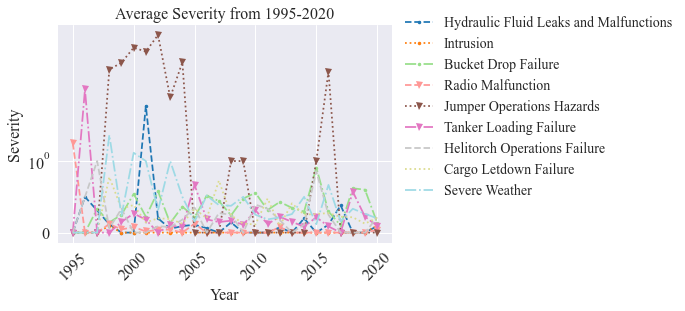

In [ ]:
plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity from 1995-2020", yscale='log', time_name='Year', show_std=False, save=False)

next, we graph the average severity over the years:

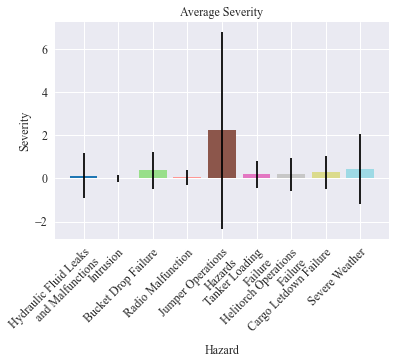

In [ ]:
plot_metric_averages(metric_data=severities, metric_name="Severity", show_std=True, title="Average Severity", save=False, legend=False, fontsize=12)

### Frequency Graphs

Now we graph the time series of hazard frequency:

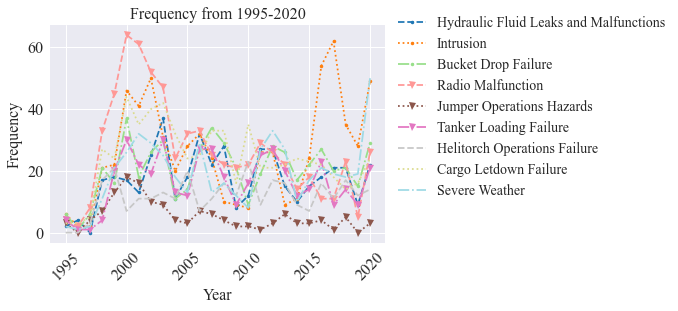

In [ ]:
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 1995-2020", time_name="Year", scale=False, save=False)

As a comparison, we also graph the rate:

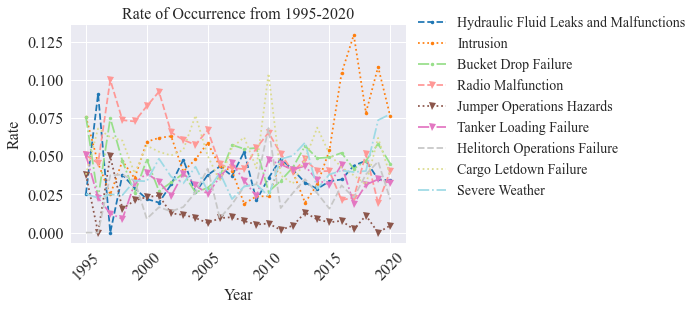

In [ ]:
plot_frequency_time_series(rates, metric_name='Rate', line_styles=line_styles, markers=markers, title="Rate of Occurrence from 1995-2020", time_name="Year", scale=False, save=False)

### Pie Charts

pie charts are graphed for the region and aircraft type categorical variables. Other variables of interest could include 'Manufacturer', 'Model', and 'Mission Type'.

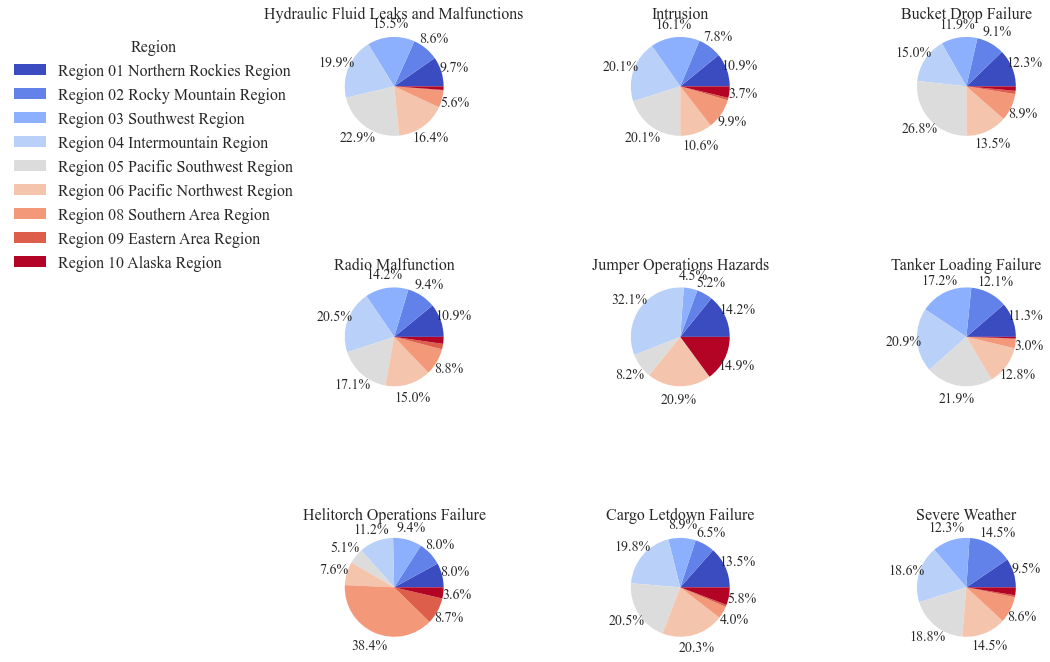

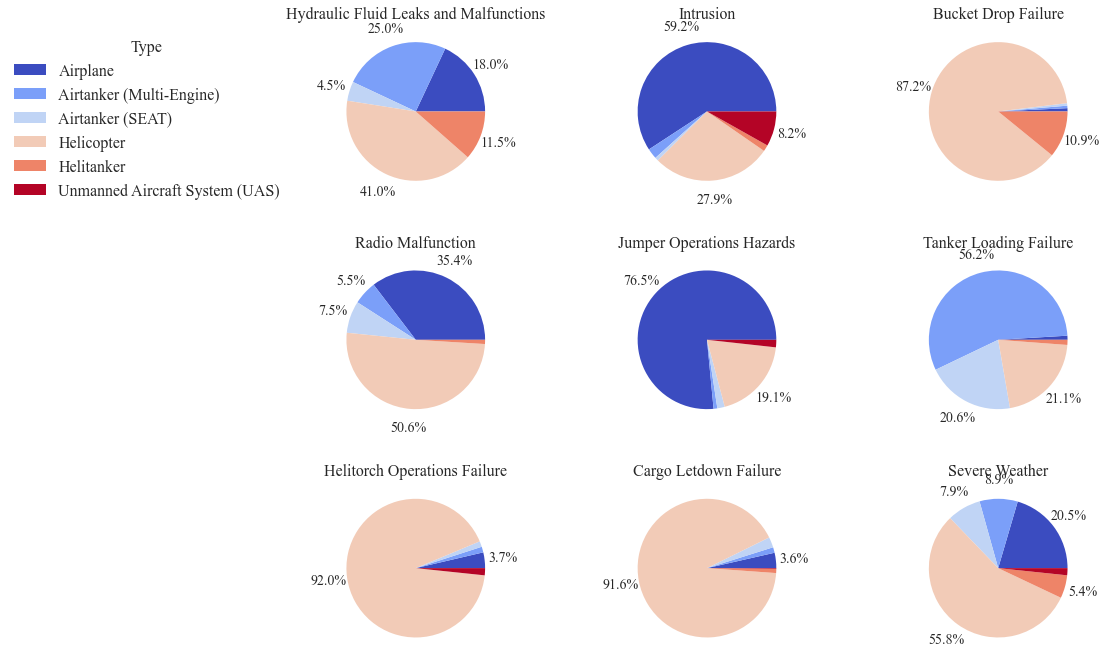

In [ ]:
predictors = ['region_corrected', 'Type']
pie_kwargs = {'pctdistance':1.27}
for predictor in predictors:
    if predictor == 'region_corrected': 
        predictor_label='Region'
    else:
        predictor_label = None
    make_pie_chart(docs, preprocessed_df, predictor, hazards, 'Tracking #', predictor_label, save=False, padding=0, pie_kwargs=pie_kwargs)

# Secondary Analysis

The secondary analysis is performed to determine if trends in the graphic analysis are statistically significant. Additionally a risk matrix is produced in this part of the analysis. This step includes:
- chi-squared analysis
- ANOVA 
- Risk matrix

### Chi-Squared Analysis

The chi-squared analysis determines if the distribution of a categorical variable, such as region, is dependent on another variable, such as the presence of a hazard. Essentially this test can determine if a hazard occurs more or less often in a certain categorical variable condition (e.g., a specific region) when compared to the complete dataset. Here we run the chi-squared test for region and aircraft type over each hazard.

To do this, we must first add hazard occurrence to the preprocessed dataframe:

In [ ]:
#add hazard values to preprocessed_df
preprocessed_df = add_hazards_to_docs(preprocessed_df, "Tracking #", docs)

Now we run the chi-squared tests, which out put a statistics dataframe and a counts dataframe

In [ ]:
pred_dict = {'region_corrected':'Region', 'Type': "Aircraft Type", 'Agency':'Agency'}
stats_df, count_dfs = chi_squared_tests(preprocessed_df, hazards, predictors, pred_dict)

c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


The resulting stats_df contains the chi-squared statistic an p-value for each hazard and predictor. A significant p-value indicates the distribution of the predictor across reports with the hazard is different than the distribution of the predictor accross reports without the hazard.

In [ ]:
stats_df

Predictor                              Region             Aircraft Type  \
Measure                                 p-val chi-squared         p-val   
Hydraulic Fluid Leaks and Malfunctions  0.001      28.908           0.0   
Intrusion                               0.004      24.521           0.0   
Bucket Drop Failure                     0.009      22.018           0.0   
Radio Malfunction                       0.018      19.994           0.0   
Jumper Operations Hazards               0.000     116.497           0.0   
Tanker Loading Failure                  0.000      50.256           0.0   
Helitorch Operations Failure            0.000     467.884           0.0   
Cargo Letdown Failure                   0.000      53.263           0.0   
Severe Weather                          0.009      22.069           0.0   

Predictor                                           
Measure                                chi-squared  
Hydraulic Fluid Leaks and Malfunctions     134.778  
Intrusion                                 1136.508  
Bucket Drop Failure                        410.215  
Radio Malfunction                          194.557  
Jumper Operations Hazards                  252.385  
Tanker Loading Failure                     936.333  
Helitorch Operations Failure               194.023  
Cargo Letdown Failure                      391.816  
Severe Weather                              27.198

In [ ]:
#print(stats_df.to_latex())

To futher examine these differences, we display the counts df. Negative count values indicate the condition occurs less there than expected, whereas positive values have the condition occur more. For example, there are more reports with hydraulic fluid leaks in region 5 than expected.

In [ ]:
for df in count_dfs:
    display(count_dfs[df])

Region 05 Pacific Southwest Region  \
Hazard                                 Present                                       
Hydraulic Fluid Leaks and Malfunctions 0                                -10.638116   
                                       1                                 10.638116   
Intrusion                              0                                  9.034818   
                                       1                                 -9.034818   
Bucket Drop Failure                    0                                -24.697554   
                                       1                                 24.697554   
Radio Malfunction                      0                                 28.822006   
                                       1                                -28.822006   
Jumper Operations Hazards              0                                 15.961198   
                                       1                                -15.961198   
Tanker Loading Failure                 0                                 -4.967652   
                                       1                                  4.967652   
Helitorch Operations Failure           0                                 47.203888   
                                       1                                -47.203888   
Cargo Letdown Failure                  0                                  6.194965   
                                       1                                 -6.194965   
Severe Weather                         0                                 11.201737   
                                       1                                -11.201737   

                                                Region 04 Intermountain Region  \
Hazard                                 Present                                   
Hydraulic Fluid Leaks and Malfunctions 0                            -12.806310   
                                       1                             12.806310   
Intrusion                              0                            -13.801928   
                                       1                             13.801928   
Bucket Drop Failure                    0                             14.397897   
                                       1                            -14.397897   
Radio Malfunction                      0                            -15.149869   
                                       1                             15.149869   
Jumper Operations Hazards              0                            -20.666959   
                                       1                             20.666959   
Tanker Loading Failure                 0                            -15.392638   
                                       1                             15.392638   
Helitorch Operations Failure           0                             19.697634   
                                       1                            -19.697634   
Cargo Letdown Failure                  0                            -10.952673   
                                       1                             10.952673   
Severe Weather                         0                             -4.655565   
                                       1                              4.655565   

                                                Region 06 Pacific Northwest Region  \
Hazard                                 Present                                       
Hydraulic Fluid Leaks and Malfunctions 0                                 -5.569277   
                                       1                                  5.569277   
Intrusion                              0                                 33.510398   
                                       1                                -33.510398   
Bucket Drop Failure                    0                                 12.234483   
                                       1                                -12.234483  

Helicopter    Airplane  \
Hazard                                 Present                           
Hydraulic Fluid Leaks and Malfunctions 0         51.354075   15.874432   
                                       1        -51.354075  -15.874432   
Intrusion                              0        180.330412 -218.654530   
                                       1       -180.330412  218.654530   
Bucket Drop Failure                    0       -181.548642  109.170265   
                                       1        181.548642 -109.170265   
Radio Malfunction                      0         41.409290  -72.800414   
                                       1        -41.409290   72.800414   
Jumper Operations Hazards              0         49.201578  -58.746554   
                                       1        -49.201578   58.746554   
Tanker Loading Failure                 0        132.920245   87.176799   
                                       1       -132.920245  -87.176799   
Helitorch Operations Failure           0       -115.367222   55.407458   
                                       1        115.367222  -55.407458   
Cargo Letdown Failure                  0       -239.655565  111.669030   
                                       1        239.655565 -111.669030   
Severe Weather                         0        -10.659947    7.550872   
                                       1         10.659947   -7.550872   

                                                Airtanker (Multi-Engine)  \
Hazard                                 Present                             
Hydraulic Fluid Leaks and Malfunctions 0                      -48.860489   
                                       1                       48.860489   
Intrusion                              0                       78.555255   
                                       1                      -78.555255   
Bucket Drop Failure                    0                       70.349534   
                                       1                      -70.349534   
Radio Malfunction                      0                       60.108836   
                                       1                      -60.108836   
Jumper Operations Hazards              0                       17.960163   
                                       1                      -17.960163   
Tanker Loading Failure                 0                     -177.905187   
                                       1                      177.905187   
Helitorch Operations Failure           0                       39.040953   
                                       1                      -39.040953   
Cargo Letdown Failure                  0                       78.635487   
                                       1                      -78.635487   
Severe Weather                         0                       26.059278   
                                       1                      -26.059278   

                                                Airtanker (SEAT)  Helitanker  \
Hazard                                 Present                                 
Hydraulic Fluid Leaks and Malfunctions 0                3.288901  -34.007330   
                                       1               -3.288901   34.007330   
Intrusion                              0               30.063023   16.583619   
                                       1              -30.063023  -16.583619   
Bucket Drop Failure                    0               24.490240  -36.941837   
                                       1              -24.490240   36.941837   
Radio Malfunction                      0              -10.729504   19.735001   
                                       1               10.729504  -19.735001   
Jumper Operations Hazards              0                5.105968    5.184846   
                                       1               -5.105968   -5.184846   
Tanker Loading Failure                 0              -64.852203   11.160067   
      

### ANOVA 

An ANOVA is performed to determine if there is a statistically siginificant difference in severity between the hazards.

To perform this, we first format the data into an AOV_df, which allows us to easily run the test.

In [ ]:
severities_dict = {hazard:[] for hazard in hazards}
AOV_df = {'hazard':[], 'severity':[]}
for hazard in hazards:
    hazard_df = preprocessed_df.loc[preprocessed_df[hazard] == 1]
    sevs = hazard_df['severity'].tolist()
    severities_dict[hazard] = sevs
    for sev in sevs:
        AOV_df['hazard'].append(hazard)
        AOV_df['severity'].append(sev)
AOV_df = pd.DataFrame(AOV_df)

Now that the data is formatted, we run the test. The Welch ANOVA is chosen because the data does not meet the criteria for a conventional ANOVA (same variances/sample sizes). The first ANOVA test we run checks if the severity between hazard and non-hazard documents is different for each hazard and the anova result is displayed.

In [ ]:
anovas = []
for hazard in hazards:
    aov = pg.welch_anova(dv='severity', between=hazard, data=preprocessed_df).round(3)
    anovas.append(aov)
anova_results = pd.concat(anovas)
anova_results

,Source,ddof1,ddof2,F,p-unc,np2
0,Hydraulic Fluid Leaks and Malfunctions,1,478.828,2.661,0.103,0.000
0,Intrusion,1,5701.889,358.199,0.000,0.002
0,Bucket Drop Failure,1,592.083,19.824,0.000,0.001
0,Radio Malfunction,1,1487.105,120.882,0.000,0.002
0,Jumper Operations Hazards,1,136.100,26.764,0.000,0.046
0,Tanker Loading Failure,1,503.159,0.870,0.351,0.000
0,Helitorch Operations Failure,1,336.694,0.272,0.602,0.000
0,Cargo Letdown Failure,1,739.366,5.336,0.021,0.000
0,Severe Weather,1,512.122,11.595,0.001,0.002


Next we run an anova between all of the hazards, resulting in one F value. This test determines if there is a difference in severity between any of the hazards.

In [ ]:
aov = pg.welch_anova(dv='severity', between='hazard', data=AOV_df).round(3)

In [ ]:
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,hazard,8,1249.299,32.573,0.0,0.098


In [ ]:
#print(aov.to_latex())

Since the ANOVA yeiled a significant result, we want to further determine which hazards are more severe than others. We do this using pairwise testing, in this case the gameshowell test.

In [ ]:
post_hoc = pg.pairwise_gameshowell(dv='severity', between='hazard',  data=AOV_df).round(3)

To simplify the results output, we filter out the results to only show hazard pairs that have a significant difference in severity

In [ ]:
post_hoc = post_hoc.loc[post_hoc['pval']<0.05].reset_index(drop=True)

In [ ]:
post_hoc = post_hoc[['A', 'B', 'df', 'T', 'pval', 'hedges']]
post_hoc.index = post_hoc['A']
post_hoc = post_hoc.drop(['A'], axis=1)
post_hoc

,B,df,T,pval,hedges
A,,,,,
Bucket Drop Failure,Helitorch Operations Failure,710.425,3.254,0.032,0.232
Bucket Drop Failure,Hydraulic Fluid Leaks and Malfunctions,876.768,3.945,0.003,0.253
Bucket Drop Failure,Intrusion,556.992,9.564,0.000,0.555
Bucket Drop Failure,Jumper Operations Hazards,138.487,-4.678,0.000,-0.448
Bucket Drop Failure,Radio Malfunction,661.035,8.361,0.000,0.484
Bucket Drop Failure,Tanker Loading Failure,947.200,3.990,0.002,0.259
Cargo Letdown Failure,Intrusion,674.026,8.586,0.000,0.476
Cargo Letdown Failure,Jumper Operations Hazards,137.672,-4.924,0.000,-0.464
Cargo Letdown Failure,Radio Malfunction,850.972,7.120,0.000,0.394


In [ ]:
#print(post_hoc.to_latex())

### Risk Matrix

To display this infomation in an accessible format, we place the hazards on a risk matrix according to USFS guidelines. 

First, configure the plotting parameters:

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "Times New Roman"

Next, assign likelihood and severity categories using the numeric hazard severity and rate values previously calculated:

In [ ]:
severities = table['Severity']
severities.index = table['Hazards']
severities_raw = severities[hazards]
severities_raw = severities_raw.to_dict()
#severities = get_SAFECOM_severity_FAA(severities_raw)
rates = table['Rate']
rates.index = table['Hazards']
rates = rates[hazards]
rates = rates.to_dict()
#likelihood = get_likelihood_FAA(rates)

In [ ]:
severities_USFS = get_SAFECOM_severity_USFS(severities_raw)
likelihood = get_likelihood_USFS(rates)

Now we can plot the risk matrix using the defined categories:

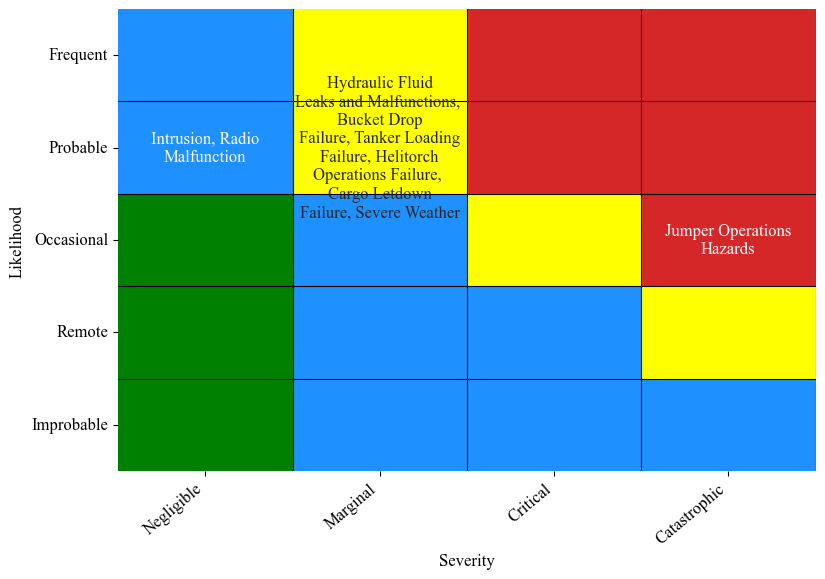

In [ ]:
plot_USFS_risk_matrix(likelihood, severities_USFS, figsize=(9,6), save=False, results_path="SAFECOM_JAIS_USFS_risk_matrix", fontsize=12, max_chars=24, title=False)

# Situation Specific Risk Matrices

To demonstrate the usefulness of this framework, we present a case study of situation specific risk matrices developed from SAFECOM reports. 

Here we define the functions needed to create these risk matrices. They include filtering the dataframe based on a set of conditions, then recalculating the hazard rate and severity for each hazard.

In [ ]:
def filter_df(df, filters):
    for col in filters:
        df = df.dropna(subset=[col])
        df = df[df[col].apply(lambda x: filters[col] in x)].reset_index(drop=True)
    return df

In [ ]:
def get_custom_rm(df, filters, hazard_file, results_file, keep_hazards=[]):
    preprocessed_df = filter_df(df, filters)
    frequency, docs, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.2)
    rates = calc_rate(frequency)
    _, severities = calc_severity_per_hazard(docs, preprocessed_df, id_field='Tracking #')
    #replace nans with 0
    severities = {hazard:severities[hazard] if (not np.isnan(severities[hazard])) else 0 for hazard in severities}
    if keep_hazards == []: keep_hazards = [hazard for hazard in docs]
    #rm extra hazards
    severities = {hazard: severities[hazard] for hazard in severities if hazard in keep_hazards}
    rates = {hazard: rates[hazard] for hazard in rates if hazard in keep_hazards}
    severities_USFS = get_SAFECOM_severity_USFS(severities)
    likelihood = get_likelihood_USFS(rates)
    plot_USFS_risk_matrix(likelihood, severities_USFS, figsize=(9,7), save=False, results_path="", fontsize=10, max_chars=30, title=False)

### Example 1: Aerial commander flying an Aero Commander airplane in California

We define the hazards to include on the custom risk matrix:

In [ ]:
keep_hazards = ['Hydraulic Fluid Leaks and Malfunctions','Intrusion','Bucket Drop Failure','Radio Malfunction','Jumper Operations Hazards',
                'Tanker Loading Failure','Helitorch Operations Failure', 'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Landing Gear Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure']

Next we specify the featues that define the scenario and get the custom risk matrix:

100%|██████████| 29/29 [00:03<00:00,  7.33it/s]
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


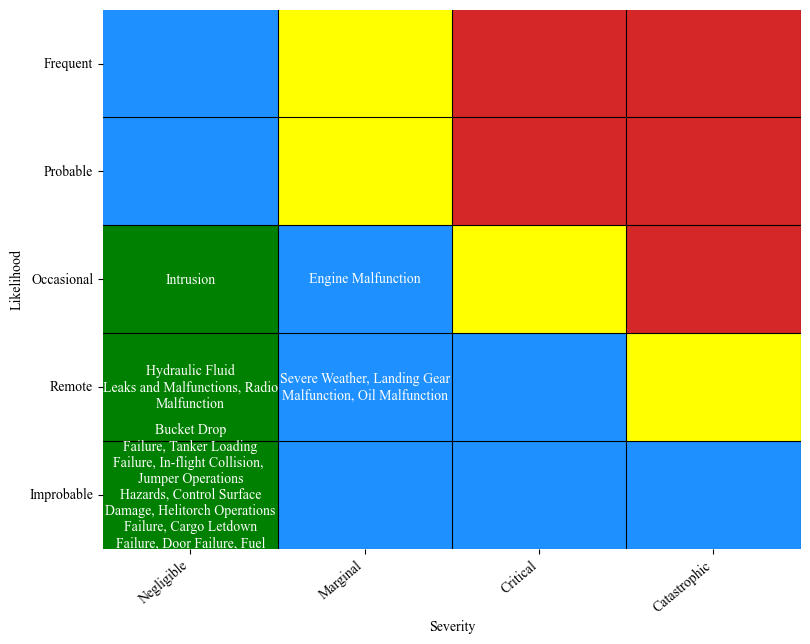

In [ ]:
filters ={"Mission Type":'Fire, Air Attack',
          "Type":'Airplane',
         "Manufacturer":'Aero Commander',
         "region_corrected":'Region 05 Pacific Southwest Region'}
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)

### Example 2: Air Tanker flying a redardant drop mission with a Lockheed multi-engine in Oregon

Again, specify the filters that define the scenario then get the risk matrix:

100%|██████████| 29/29 [00:02<00:00, 12.22it/s]


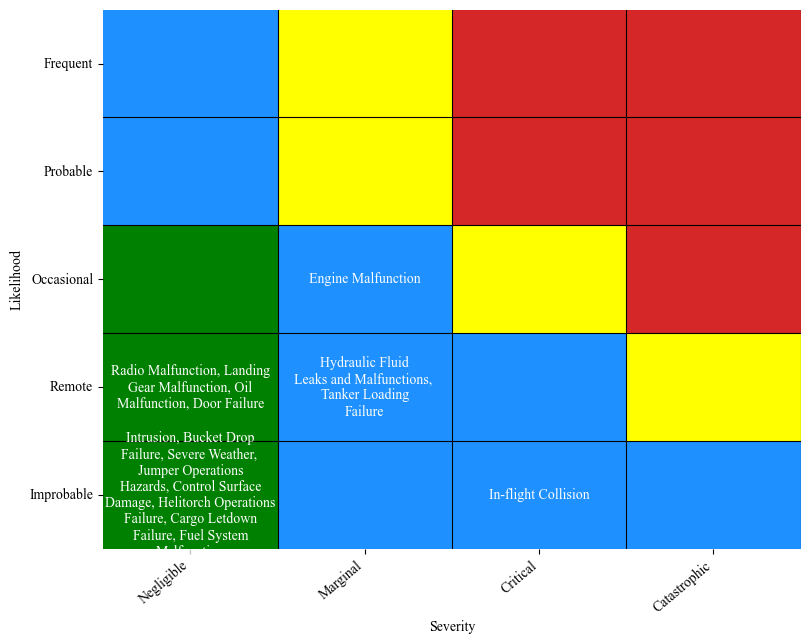

In [ ]:
filters ={"Mission Type":'Fire, Retardant Drop (Airtanker)',
         "Type":'Airtanker (Multi-Engine)',
          "Manufacturer": "Lockheed",
         'region_corrected':'Region 06 Pacific Northwest Region'}
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)

### Example 3: Pilot flying a Bell Helicopter for reconnaisance in Texas

In addition to specifying the filters, for this risk matrix we also define a new list of hazards that are more relevant to this scenario:

100%|██████████| 29/29 [00:01<00:00, 14.74it/s]


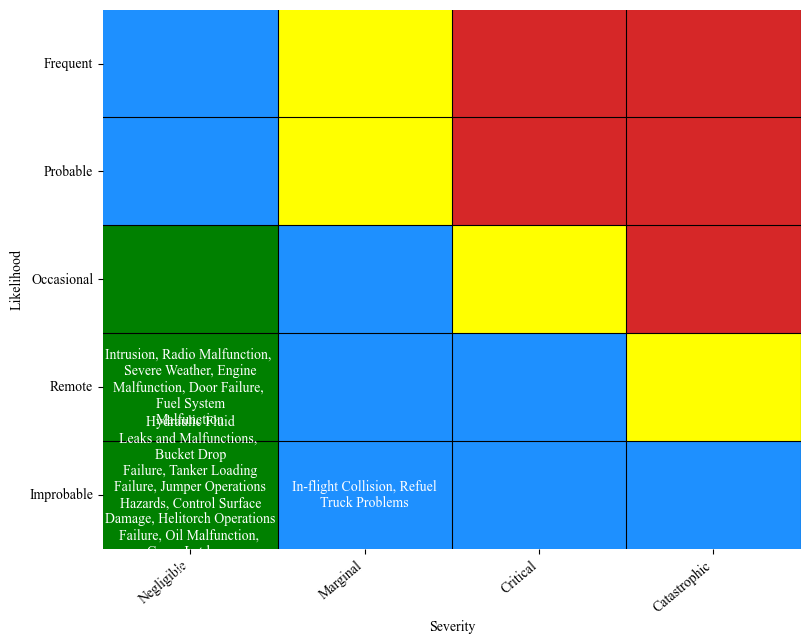

In [ ]:
filters ={"Mission Type":'Fire, Reconnaissance',
         "Type":'Helicopter',
          "Manufacturer": "Bell",
          #"Model":"600",#includes 600
          'region_corrected':'Region 08 Southern Area Region'}
keep_hazards = ['Hydraulic Fluid Leaks and Malfunctions','Intrusion','Bucket Drop Failure','Radio Malfunction','Jumper Operations Hazards',
                'Tanker Loading Failure','Helitorch Operations Failure', 'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure', 'Refuel Truck Problems']
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)